In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from time import time
import warnings
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('df.csv')

In [4]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,product_id,seller_id,price,...,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name,product_photos_qty,seller_zip_code_prefix,seller_state,customer_order_counts
0,55f3757ef1ecbd686debb21f5a2521c4,c3a1aa867de7bbc426695e756107ed38,13172,sumare,SP,73ed85f5462f78670fcd66c2ccd79f06,2017-07-13 19:56:22,dbf47a585df3a9d8f0b5f4c125a2b8e8,7c67e1448b00f6e969d365cea6b010ab,144.99,...,1.0,credit_card,8.0,163.72,5,moveis_escritorio,1.0,8577,SP,2
1,422dfe12ed7978978abbedd5c706891f,c3a1aa867de7bbc426695e756107ed38,13172,sumare,SP,356c676af9d2b3828c504330ea74ed73,2017-07-17 08:20:44,805fb04b1eee16776d3ff45a40a30044,7c67e1448b00f6e969d365cea6b010ab,119.99,...,1.0,credit_card,6.0,137.56,5,moveis_escritorio,2.0,8577,SP,2
2,11d40dac62f72f261e07972e70617fbd,88133d61eda1c59a2db4266167f5747a,37640,extrema,MG,bd6a1bf9e611f39801013f5c1f0f14cc,2018-03-23 17:03:49,1bfb290d7273a442c874dbe74b4abae6,7c67e1448b00f6e969d365cea6b010ab,69.99,...,1.0,credit_card,6.0,190.20,3,moveis_escritorio,1.0,8577,SP,2
3,11d40dac62f72f261e07972e70617fbd,88133d61eda1c59a2db4266167f5747a,37640,extrema,MG,bd6a1bf9e611f39801013f5c1f0f14cc,2018-03-23 17:03:49,1bfb290d7273a442c874dbe74b4abae6,7c67e1448b00f6e969d365cea6b010ab,69.99,...,1.0,credit_card,6.0,190.20,3,moveis_escritorio,1.0,8577,SP,2
4,59954950b484751adc5d8191bcd1f8ef,204411895cd94da85bf16cdd8b6fafb2,24440,sao goncalo,RJ,dbb320039cf47fdcb45445cfb453689d,2017-12-08 00:15:46,3eef0cb94ba82de806bb30ab743c7655,7c67e1448b00f6e969d365cea6b010ab,79.99,...,1.0,credit_card,4.0,205.74,3,moveis_escritorio,1.0,8577,SP,2


In [5]:
data.shape

(9259, 21)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9259 entries, 0 to 9258
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               9259 non-null   object 
 1   customer_unique_id        9259 non-null   object 
 2   customer_zip_code_prefix  9259 non-null   int64  
 3   customer_city             9259 non-null   object 
 4   customer_state            9259 non-null   object 
 5   order_id                  9259 non-null   object 
 6   order_purchase_timestamp  9259 non-null   object 
 7   product_id                9259 non-null   object 
 8   seller_id                 9259 non-null   object 
 9   price                     9259 non-null   float64
 10  freight_value             9259 non-null   float64
 11  payment_sequential        9259 non-null   float64
 12  payment_type              9259 non-null   object 
 13  payment_installments      9259 non-null   float64
 14  payment_

In [7]:
data['order_purchase_timestamp']

0       2017-07-13 19:56:22
1       2017-07-17 08:20:44
2       2018-03-23 17:03:49
3       2018-03-23 17:03:49
4       2017-12-08 00:15:46
               ...         
9254    2018-01-05 17:08:19
9255    2018-01-05 17:08:19
9256    2017-11-14 19:11:32
9257    2018-01-17 10:43:45
9258    2018-01-17 10:43:45
Name: order_purchase_timestamp, Length: 9259, dtype: object

In [8]:
categorical_features = list(data.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
categorical_features

['customer_id',
 'customer_unique_id',
 'customer_city',
 'customer_state',
 'order_id',
 'order_purchase_timestamp',
 'product_id',
 'seller_id',
 'payment_type',
 'product_category_name',
 'seller_state']

# I. Segmentation RFM : 

Nous allons calculer les trois variables : 

**Recency** : nombre de jours depuis la dernière transaction du client. 

**Frequency** : nombre de transactions au cours des 23 mois.

**Monetary Value** :  dépenses totales au cours des 23 mois


In [9]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [10]:
print('Min:{}; Max:{}'.format(min(data.order_purchase_timestamp),
max(data.order_purchase_timestamp)))

Min:2016-10-04 22:03:46; Max:2018-08-28 21:56:12


In [11]:
snapshot_date = max(data['order_purchase_timestamp']) + dt.timedelta(days=1,  hours=24, minutes=60)

In [12]:
data.rename(columns={'customer_order_counts': 'order_frequency'}, inplace=True)
data.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,product_id,seller_id,price,...,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name,product_photos_qty,seller_zip_code_prefix,seller_state,order_frequency
0,55f3757ef1ecbd686debb21f5a2521c4,c3a1aa867de7bbc426695e756107ed38,13172,sumare,SP,73ed85f5462f78670fcd66c2ccd79f06,2017-07-13 19:56:22,dbf47a585df3a9d8f0b5f4c125a2b8e8,7c67e1448b00f6e969d365cea6b010ab,144.99,...,1.0,credit_card,8.0,163.72,5,moveis_escritorio,1.0,8577,SP,2
1,422dfe12ed7978978abbedd5c706891f,c3a1aa867de7bbc426695e756107ed38,13172,sumare,SP,356c676af9d2b3828c504330ea74ed73,2017-07-17 08:20:44,805fb04b1eee16776d3ff45a40a30044,7c67e1448b00f6e969d365cea6b010ab,119.99,...,1.0,credit_card,6.0,137.56,5,moveis_escritorio,2.0,8577,SP,2
2,11d40dac62f72f261e07972e70617fbd,88133d61eda1c59a2db4266167f5747a,37640,extrema,MG,bd6a1bf9e611f39801013f5c1f0f14cc,2018-03-23 17:03:49,1bfb290d7273a442c874dbe74b4abae6,7c67e1448b00f6e969d365cea6b010ab,69.99,...,1.0,credit_card,6.0,190.20,3,moveis_escritorio,1.0,8577,SP,2


In [13]:
data_rfm = data.groupby(['customer_unique_id']).agg({
'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
'order_frequency' : 'count',
'payment_value': 'sum'})
data_rfm.sample(3)


,order_purchase_timestamp,order_frequency,payment_value
customer_unique_id,,,
7395a64f37a30f9827ca4d8292b484e8,359,2,153.37
a6303dd3323275ac03b5c38a55a16659,119,2,279.88
0f0e48a91c9c285404572b095bcb373c,406,2,204.54


In [14]:
data_rfm.shape

(4005, 3)

In [15]:
# Rename columns for easier interpretation
data_rfm.rename(columns = {'order_purchase_timestamp': 'Recency',
'order_frequency': 'Frequency',
'payment_value': 'MonetaryValue'}, inplace=True)
# Check the first rows
data_rfm.sample(3)

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
4222f488432f87a3cf7a836582378acc,539,3,217.74
b8b6643025dbcaa0e516a72f6d0d0717,388,2,244.44
c2c7712d6c0a2ac5be6a3280042d471b,464,2,192.60


In [16]:
data_rfm.shape

(4005, 3)

# I. Segmentation RFM 

**I.1 Segmentation RFM basée sur les quartiles**

Nous divisons d'abord chacune de nos trois variables RFM en quatre quartiles et déduisons un score permettant de classer nos clients. 

In [17]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(data_rfm['Recency'], 4, labels = r_labels)

In [18]:
f_quartiles = pd.qcut(data_rfm['Frequency'].rank(method= 'first'), 4, ['1','2','3','4'])

In [19]:
m_labels = range(1,5)
m_quartiles = pd.qcut(data_rfm['MonetaryValue'], 4, labels = m_labels)

In [20]:
data_rfm_scores= data_rfm.assign(r_score = r_quartiles.values, f_score = f_quartiles.values, m_score = m_quartiles.values)

In [21]:
data_rfm_scores.head()

,Recency,Frequency,MonetaryValue,r_score,f_score,m_score
customer_unique_id,,,,,,
000bfa1d2f1a41876493be685390d6d3,335,2,93.70,2,1,1
001147e649a7b1afd577e873841632dd,364,2,424.32,1,1,4
003e2af81ea3c72fbdd093f07724a4de,136,2,127.48,3,1,1
004f84d065096f3cedd26cf0adc80b9d,126,2,378.16,3,1,4
00504b68faa074d0f40adcb4f7727f71,18,2,397.40,4,1,4


In [22]:
Le score par afecté à chaque client sera égal au nombre entier composé 

SyntaxError: invalid syntax (3350604183.py, line 1)

In [23]:
data_rfm_scores['rfm_score'] = 100 * data_rfm_scores['r_score'].astype(int) + 10 * data_rfm_scores['f_score'].astype(int)+ data_rfm_scores['m_score'].astype(int)
data_rfm_scores.head()

,Recency,Frequency,MonetaryValue,r_score,f_score,m_score,rfm_score
customer_unique_id,,,,,,,
000bfa1d2f1a41876493be685390d6d3,335,2,93.70,2,1,1,211
001147e649a7b1afd577e873841632dd,364,2,424.32,1,1,4,114
003e2af81ea3c72fbdd093f07724a4de,136,2,127.48,3,1,1,311
004f84d065096f3cedd26cf0adc80b9d,126,2,378.16,3,1,4,314
00504b68faa074d0f40adcb4f7727f71,18,2,397.40,4,1,4,414


In [24]:
#datamart_rfm=datamart_scores.drop(['r_score', 'f_score', 'm_score'], axis=1)
#datamart_rfm.head()

In [25]:
data_rfm_scores.groupby('rfm_score').size().sort_values(ascending=False)[:10]

rfm_score
244    163
444    135
344    126
144    125
121     88
323     82
421     81
311     81
131     80
221     80
dtype: int64

Regardons de prêt les 5 premières lignes ayant un score 111

In [26]:
rfm_111=data_rfm_scores.loc[data_rfm_scores['rfm_score']==111]
rfm_111.head()

,Recency,Frequency,MonetaryValue,r_score,f_score,m_score,rfm_score
customer_unique_id,,,,,,,
018b5a7502c30eb5f230f1b4eb23a156,375,2,110.18,1,1,1,111
024741ae16493ea617e06ecc277c7069,433,2,132.68,1,1,1,111
02ab167135d5d29cdc77b3147d75c1ef,526,2,106.84,1,1,1,111
031ea691b99fc101dcad357d1a83573f,416,2,73.04,1,1,1,111
0339119d431b8dd1b361567e4fc48a58,418,2,131.36,1,1,1,111


In [27]:
max_rfm = data_rfm_scores['rfm_score'].max()
min_rfm = data_rfm_scores['rfm_score'].min()
mean_rfm =data_rfm_scores['rfm_score'].mean()

print("Valeur maximale de RFM score:", max_rfm)
print("Valeur minimale de RFM score:", min_rfm)
print("Moyenne de RFM score:", mean_rfm)


Valeur maximale de RFM score: 444
Valeur minimale de RFM score: 111
Moyenne de RFM score: 277.70811485642946


In [28]:
data_rfm_scores_mean =data_rfm_scores.groupby('rfm_score').agg({
'Recency': 'mean','Frequency': 'mean','MonetaryValue': 'mean' }).round(1)
data_rfm_scores_mean.head()

,Recency,Frequency,MonetaryValue
rfm_score,,,
111,450.8,2.0,114.5
112,443.3,2.0,193.3
113,431.9,2.0,285.2
114,442.2,2.0,404.7
121,447.8,2.0,112.4


**I.2 Segemntation RFM à l'aide des quartiles**

In [29]:
Q1_rfm = data_rfm_scores['rfm_score'].quantile(0.25)
mid_rfm = data_rfm_scores['rfm_score'].quantile(0.50)
Q3_rfm = data_rfm_scores['rfm_score'].quantile(0.75)
print(Q1_rfm, mid_rfm, Q3_rfm)

211.0 311.0 411.0


In [30]:
def segment_me(df):
    if df['rfm_score'] >= 411:
        return 'Gold'
    elif (df['rfm_score'] >= 311) and (df['rfm_score'] < 411):
        return 'Silver'
    else:
        return 'Bronze'

In [31]:
data_rfm_scores['General_Segment'] = data_rfm_scores.apply(segment_me, axis=1)

In [32]:
data_rfm_segments =data_rfm_scores.groupby('General_Segment').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count']
}).round(1).sort_values(('Recency', 'mean'))
data_rfm_segments

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Gold               56.2       2.3         271.1  1003
Silver            160.1       2.3         272.9  1000
Bronze            360.8       2.3         275.3  2002

**I.2 Segmentation RFM avec l'algorithme k-means**

**i. Hypothèses**:

1. Distributions symétriques des variables. 
2. Varaibles avec la même moyenne et variance. 


**ii.Preprocessing**

In [33]:
data_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4005.000000,4005.000000,4005.000000
mean,234.377778,2.311860,273.629393
std,150.734343,0.769921,175.124826
min,2.000000,2.000000,19.040000
25%,110.000000,2.000000,152.690000
50%,216.000000,2.000000,235.450000
75%,346.000000,2.000000,346.640000
max,695.000000,12.000000,2090.440000


Les hypothèse citées ci-dessus ne sont pas vérifiées. 

Commençons d'abord par regarder les distributions de nos trois variables : 

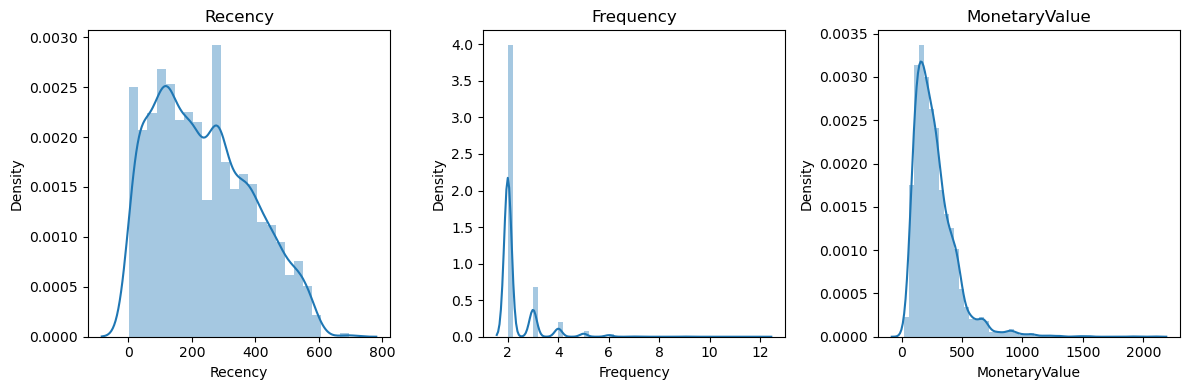

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.distplot(data_rfm['Recency'], ax=axes[0])
axes[0].set_title('Recency')

sns.distplot(data_rfm['Frequency'], ax=axes[1])
axes[1].set_title('Frequency')

sns.distplot(data_rfm['MonetaryValue'], ax=axes[2])
axes[2].set_title('MonetaryValue')

plt.tight_layout()
plt.savefig('distri_rfm')
plt.show()


In [37]:
data_rfm_cols=['Recency', 'Frequency', 'MonetaryValue']

In [229]:
from sklearn.preprocessing import FunctionTransformer
data_rfm_log = np.log(data_rfm)

In [39]:
from sklearn.preprocessing import normalize
data_rfm_normalized = normalize(data_rfm_log, norm='l2')

In [40]:
data_rfm_normal_df = pd.DataFrame(data_rfm_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])

**Étapes clés**

1. Choix d'un nombre de clusters
2. Exécution du clustering k-means sur les données pré-traitées
3. Analyse des valeurs moyennes RFM de chaque cluster

In [43]:
from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=2, random_state=1)

In [44]:
kmeans2.fit(data_rfm_normal_df)

KMeans(n_clusters=2, random_state=1)

In [45]:
cluster_labels_2 = kmeans2.labels_

**Analisons la moyenne des valeurs RFM pour chaque cluster**

In [46]:
cluster_labels_2 = pd.Series(cluster_labels_2, index=data_rfm_normal_df.index, name='Cluster')
data_rfm_k2 = pd.concat([data_rfm_normal_df, cluster_labels_2], axis=1)
data_rfm_k2.sample(5)

,Recency,Frequency,MonetaryValue,Cluster
1607,0.731106,0.080787,0.677464,0
351,0.603858,0.091088,0.791870,1
1731,0.734209,0.084523,0.673642,0
2481,0.649434,0.155659,0.744316,0
607,0.748674,0.085450,0.657408,0


In [47]:
data_rfm_k2.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': 'mean'}).round(0)


,Recency,Frequency,MonetaryValue
Cluster,,,
0,1.0,0.0,1.0
1,1.0,0.0,1.0


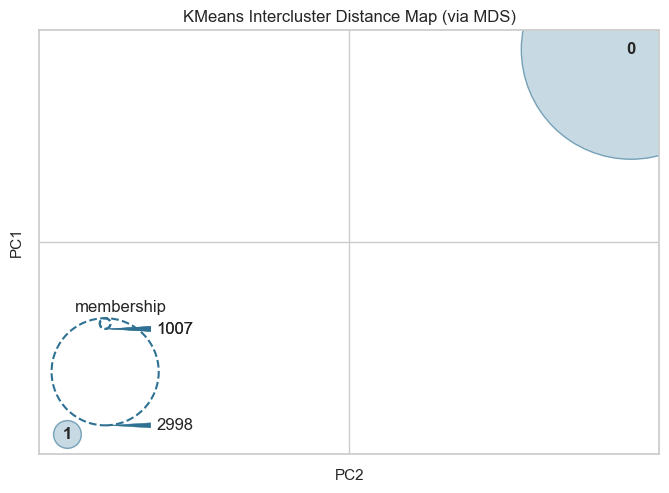

<Figure size 800x550 with 0 Axes>

In [49]:
from yellowbrick.cluster import InterclusterDistance

# Création de l'objet InterclusterDistance et visualisation
visualizer = InterclusterDistance(kmeans2)
visualizer.fit(data_rfm_normal_df)
visualizer.show()
plt.savefig('distance_clusters_kmeans2')

**Choix du nombre de clusters**

**Méthodes**

1. Méthode visuelle  - critère du coude 
2. Méthode mathématique  - coefficient de silhouette

Méthode du critère du coude : 

1. On trace le nombre de clusters en fonction de la somme des carrés des erreurs intra-cluster (SSE)- somme des distances au carré de chaque point de données à leur centre de cluster.
2. On identifie le "coude" dans le tracé. 
3. le Coude est un point représentant un nombre de clusters "optimal".

In [50]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_rfm_normal_df)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster centers

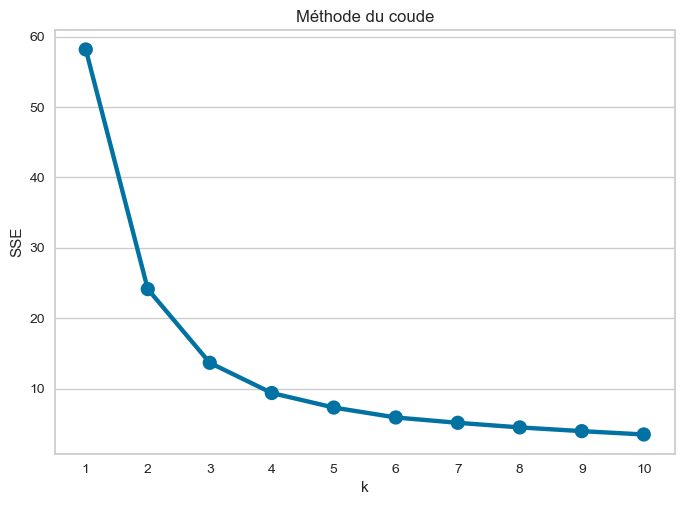

In [51]:
# Plot SSE for each *k*
plt.title('Méthode du coude')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.savefig('elobw_rfm')
plt.show()

La méthode du coude nous indique que le meilleur nombre de clusters est entre 3 et 4. 

**Anayse de la silhouette**

In [52]:
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_rfm_normal_df)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(data_rfm_normal_df, cluster_labels)
    print("Pour n_clusters={0}, le silhouette score est {1}".format(num_clusters, silhouette_avg))

Pour n_clusters=2, le silhouette score est 0.5670580936489371
Pour n_clusters=3, le silhouette score est 0.48315972577297617
Pour n_clusters=4, le silhouette score est 0.45067924735826437
Pour n_clusters=5, le silhouette score est 0.4306696492031905
Pour n_clusters=6, le silhouette score est 0.4216776903778302
Pour n_clusters=7, le silhouette score est 0.43414421529941843
Pour n_clusters=8, le silhouette score est 0.4131502552352538


In [53]:
kmeans4=KMeans(n_clusters=4, random_state=42)
kmeans4.fit(data_rfm_normal_df)

KMeans(n_clusters=4, random_state=42)

In [54]:
data_rfm['Cluster'] = kmeans4.predict(data_rfm_normal_df)
data_rfm_4 = data_rfm.copy()
data_rfm_4.sample(5)

,Recency,Frequency,MonetaryValue,Cluster
customer_unique_id,,,,
6db178649b8d1204db26f123bc69a81b,376,3,396.90,0
fcb4153eee858c085c357f0511e0e520,31,2,99.12,2
2d511ba1ec0a22de693b9492d6e4e67a,394,2,151.00,3
9c3a23565ded3e71fc8979579e8f091c,232,2,69.54,3
3f591bdca999989260411d00a0bcd57e,7,2,140.00,1


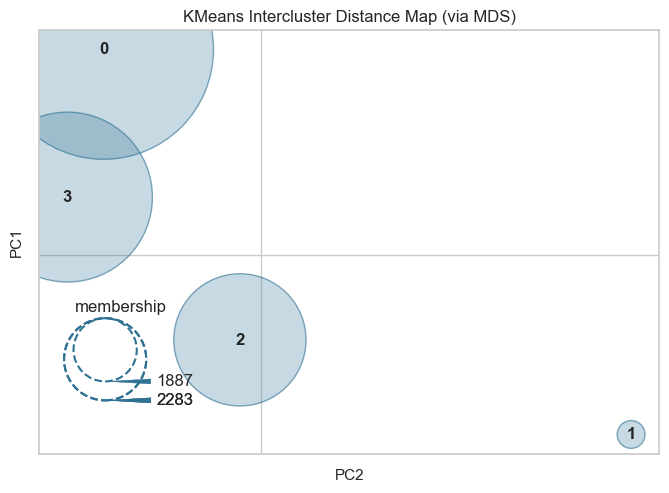

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [214]:
# Création de l'objet InterclusterDistance et visualisation
visualizer = InterclusterDistance(kmeans4)
visualizer.fit(data_rfm_4)
plt.savefig('distance_clusters_kmeans4')
visualizer.show()


Vérifions la distance interclusters pour k=3

In [57]:
kmeans3=KMeans(n_clusters=3, random_state=42)
kmeans3.fit(data_rfm_normal_df)

KMeans(n_clusters=3, random_state=42)

In [58]:
data_rfm['Cluster'] = kmeans3.predict(data_rfm_normal_df)
data_rfm_3=data_rfm.copy()
data_rfm_3.sample(5)

,Recency,Frequency,MonetaryValue,Cluster
customer_unique_id,,,,
6cf4228e1512fc12c0d2b932cca21bdc,23,2,207.72,0
2445ba0a1c56ba4a3d4e202dc471aacc,204,2,276.96,2
62204ea371bf14716930a74c996332a8,345,2,292.60,1
79b9e9b310f3094c2cad708eb17508c2,363,2,67.80,1
c988628b7bc5d9c645eb7a3a66f31b46,185,2,165.35,1


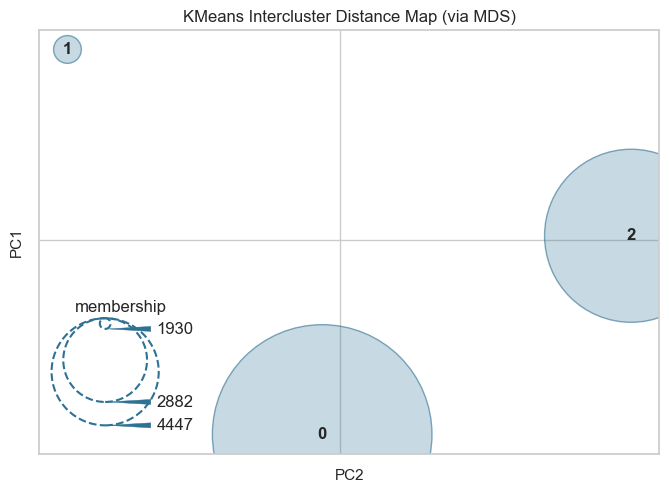

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [215]:
visualizer = InterclusterDistance(kmeans3)
visualizer.fit(data_rfm_3)
plt.savefig('distance_clusters_kmeans3')
visualizer.show()


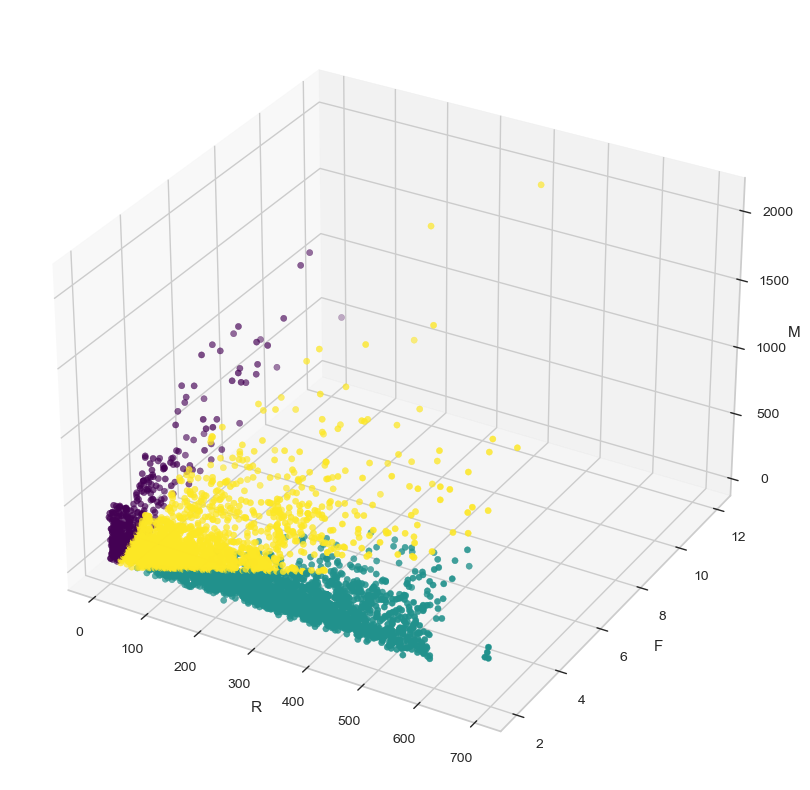

In [217]:
from mpl_toolkits.mplot3d import Axes3D

# Définir les variables RFM
R = data_rfm_3['Recency']
F = data_rfm_3['Frequency']
M = data_rfm_3['MonetaryValue']

# Définir les labels de cluster
labels = data_rfm_3['Cluster']

# Créer une figure 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Tracer les points de données en 3D
ax.scatter(R, F, M, c=labels, cmap='viridis')

# Étiqueter les axes
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.savefig('scatter_clusters_kmeans3')
# Afficher la figure
plt.show()


Les scores de la silhouette ainsi que la visualisation des distances interclusters nous indiquent que le meilleur meilleur nombre de clusters pour les trois variables RFM est égal à 3. 

# III. Segmentation k-means sur RFM et  d'autres features

**1. Preprocessing**

In [60]:
numerical_features = list(data.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['customer_zip_code_prefix',
 'price',
 'freight_value',
 'payment_sequential',
 'payment_installments',
 'payment_value',
 'review_score',
 'product_photos_qty',
 'seller_zip_code_prefix',
 'order_frequency']

In [61]:
data[numerical_features].sample(3)

,customer_zip_code_prefix,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_photos_qty,seller_zip_code_prefix,order_frequency
2885,12517,49.28,12.69,1.0,6.0,61.97,5,1.0,14940,2
4806,8215,29.00,12.13,1.0,2.0,123.39,5,3.0,13232,3
499,24754,35.00,16.44,1.0,1.0,154.32,3,1.0,3204,3


In [62]:
select_num_features = ['customer_zip_code_prefix', 'price', 'review_score', 'seller_zip_code_prefix']

In [63]:
data_num_feat=data[['customer_unique_id', 'order_purchase_timestamp'] + select_num_features]

In [64]:
valeurs_uniques = data_num_feat['review_score'].unique()
print(valeurs_uniques)

[5 3 4]


In [65]:
data_rfm_num_feat = data_rfm.merge(data_num_feat, on='customer_unique_id', how='inner')
data_rfm_num_feat.sample(3)

,customer_unique_id,Recency,Frequency,MonetaryValue,Cluster,order_purchase_timestamp,customer_zip_code_prefix,price,review_score,seller_zip_code_prefix
2463,460cd758614a0be9739d2f8d9bc1494d,293,2,310.28,1,2017-11-10 15:36:04,35437,59.90,5,15025
7923,d8d7254ce52510c5a5c38db3ab5b9c4e,4,2,99.12,0,2018-08-26 20:06:40,4119,11.99,5,14940
32,013f4353d26bb05dc6652f1269458d8d,275,2,328.08,2,2017-11-28 13:30:58,44065,64.00,5,14070


In [66]:
data_rfm_num_feat.shape

(9259, 10)

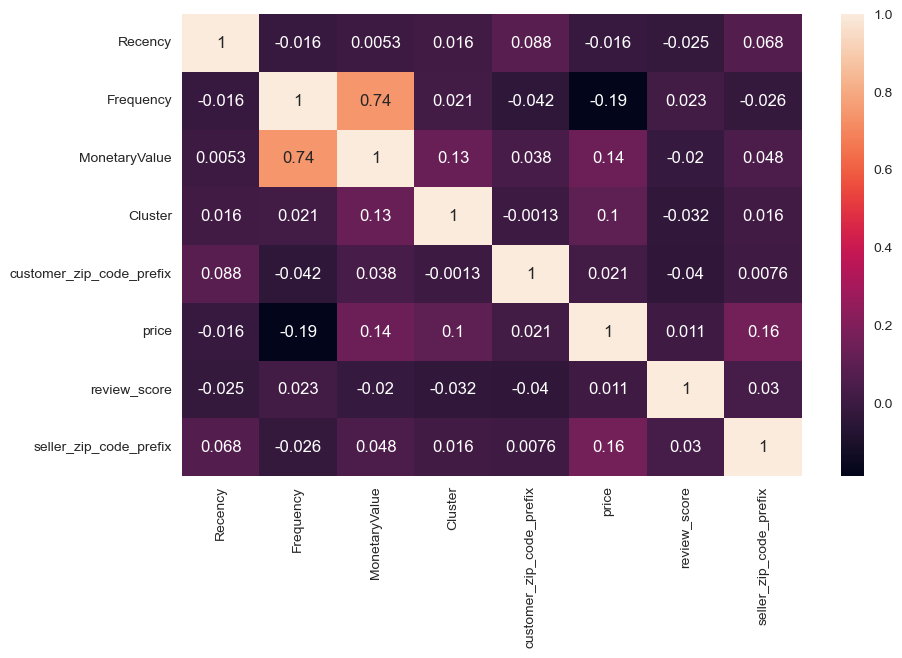

In [67]:
# Show Correlation between Features
plt.figure(figsize= [10, 6])
sns.heatmap(data_rfm_num_feat.corr(), annot= True)
plt.savefig('matrix_corr')

In [68]:
numeric_cols =data_rfm_num_feat.drop(['customer_unique_id','order_purchase_timestamp'], axis=1)

In [69]:
data_log=np.log(numeric_cols)

In [70]:
numeric_cols_normalized = normalize(numeric_cols, norm='l2')
num_cols_df= pd.DataFrame(numeric_cols_normalized, columns=numeric_cols.columns)

In [71]:
k_values = range(1, 12)
# Stocker les résultats pour chaque valeur de k
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(num_cols_df)
    
    # Stocker l'inertie pour chaque valeur de k
    inertias.append(kmeans.inertia_)

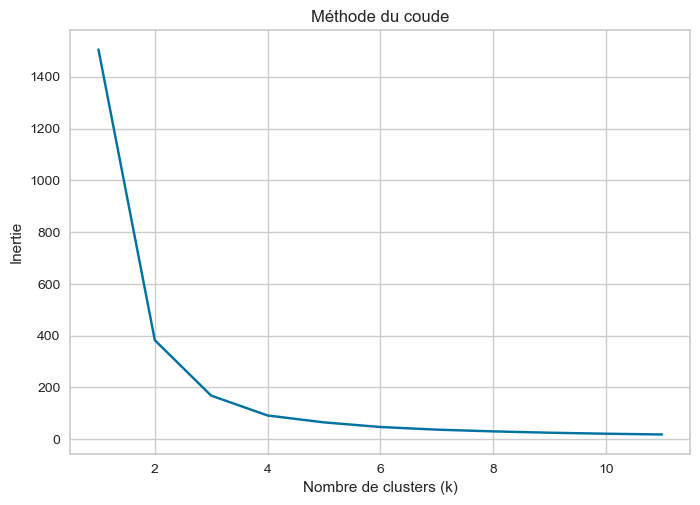

In [72]:
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.savefig('elobw_rfm_feat')
plt.show()

On remarque que le coude si situe entre 3 et 4. 

In [73]:
kmeans4.fit(num_cols_df)

KMeans(n_clusters=4, random_state=42)

In [74]:
data_rfm_num_feat['Cluster'] = kmeans4.predict(num_cols_df)
data_rfm_num_feat_4=data_rfm_num_feat.copy()
data_rfm_num_feat_4.sample(5)

,customer_unique_id,Recency,Frequency,MonetaryValue,Cluster,order_purchase_timestamp,customer_zip_code_prefix,price,review_score,seller_zip_code_prefix
3815,6acbd95f502950f253a1d4d8c6b0f486,481,2,135.44,1,2017-05-06 11:50:18,2955,22.90,5,14940
9019,f8225ebff85ec458f5ccaf4adc3d2dbe,21,2,273.40,1,2018-08-09 15:53:34,11628,49.90,4,21041
7566,d014f51b7dd542baedb3b0699a2a53ba,59,2,96.36,1,2018-07-02 07:52:38,2515,36.20,5,11704
8322,e38bf9a883752b0b65407a103fd7ef30,240,2,261.15,3,2017-11-29 11:26:51,23093,30.90,5,14940
623,1270b69469b516c18f61138f16cda7aa,511,2,134.04,0,2017-04-06 13:02:52,28895,18.99,3,8250


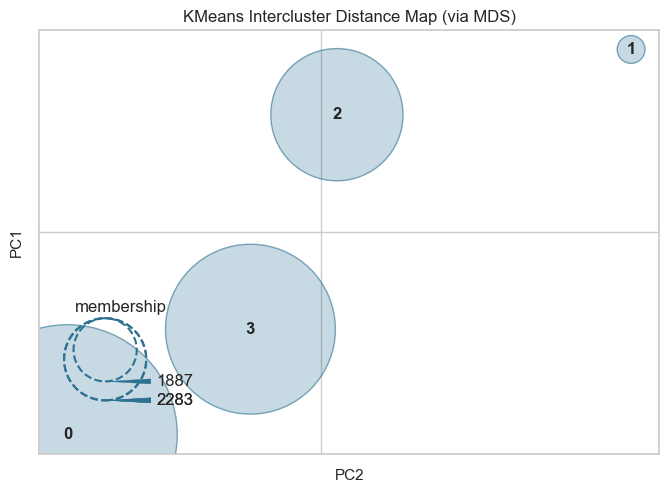

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [76]:
visualizer = InterclusterDistance(kmeans4)
visualizer.fit(data_rfm_num_feat_4)
plt.savefig('distance_clusters_kmeans4_rfm_feat')
visualizer.show()

In [77]:
kmeans3.fit(num_cols_df)

KMeans(n_clusters=3, random_state=42)

In [78]:
data_rfm_num_feat['Cluster'] = kmeans3.predict(num_cols_df)
data_rfm_num_feat_3=data_rfm_num_feat.copy()
data_rfm_num_feat_3.sample(5)

,customer_unique_id,Recency,Frequency,MonetaryValue,Cluster,order_purchase_timestamp,customer_zip_code_prefix,price,review_score,seller_zip_code_prefix
5103,8e2cbe0458411443853166c1a81d2f9d,8,2,283.56,1,2018-08-22 15:14:14,3029,49.90,5,15025
3320,5e52bf13fe3f774f2fb146c8096dd840,518,2,302.12,2,2017-03-30 21:36:05,23088,59.90,5,13076
6191,ab36c217295b324208ad9b56d4ea4af9,458,2,239.36,2,2017-05-29 20:17:31,14169,47.99,4,13920
7427,cc3fa56799bf052b6f877995f7cc592e,167,2,249.32,0,2018-03-15 23:52:07,8533,49.90,4,3471
1738,310647380793836bfa5b7b6b3f518423,316,9,1912.04,2,2017-10-18 13:34:48,14095,16.90,5,9710


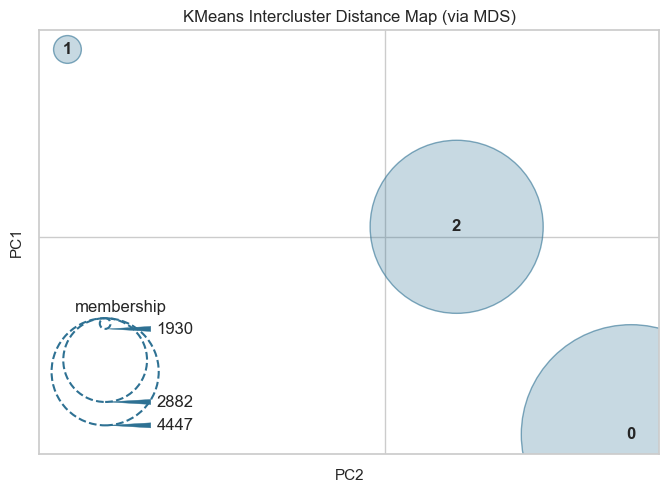

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [79]:
visualizer = InterclusterDistance(kmeans3)
visualizer.fit(data_rfm_num_feat_3)
plt.savefig('distance_clusters_rfm_feat_kmeans3')
visualizer.show()

Nous pouvons maintenant confirmer le choix de 3 clusters pour notre segmentation. 

**Stabilité à l'initialisation du K-Means**

Nous allons évaluer la stabilité à l'initialisation en effectuant plusieurs ajustements de modèle avec différentes initialisations

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score as ARI


X = data_rfm_num_feat.drop(['customer_unique_id','order_purchase_timestamp','Cluster'], axis=1) 
X_normal= normalize(X)
X_train, X_test = train_test_split(X_normal, test_size=0.3, random_state=0)
X_test_df = pd.DataFrame(X_test, columns=X.columns)


In [81]:
n_init = 10  # nombre d'initialisations aléatoires
scores = []
for i in range(n_init):
    kmeans = KMeans(n_clusters=4, random_state=i)
    kmeans.fit(X_train)
    cluster_labels = kmeans.predict(X_test)
    score = ARI(data_rfm_num_feat['Cluster'].loc[X_test_df.index], cluster_labels)
    scores.append(score)

# Afficher les scores de similarité ajustée pour chaque initialisation
print("Scores de similarité ajustée pour les {} initialisations aléatoires:".format(n_init))
print(scores)

# Afficher la moyenne et l'écart type des scores
print("Score moyen: {:.2f}".format(np.mean(scores)))
print("Écart type des scores: {:.2f}".format(np.std(scores)))


Scores de similarité ajustée pour les 10 initialisations aléatoires:
[-0.0009048003354065429, -0.0009048003354065429, -0.0009048003354065429, -0.0009048003354065429, -0.0009270448891465463, -0.0009048003354065429, -0.0009048003354065429, -0.0009048003354065429, -0.0009048003354065429, -0.0009270448891465463]
Score moyen: -0.00
Écart type des scores: 0.00


# Algorithme DBSCAN

In [82]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=8)

clusters = dbscan.fit_predict(numeric_cols)
                             

print("Clusters attribués :")
print(clusters)

# Nombre de clusters attribués
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print("Nombre de clusters :", n_clusters)


Clusters attribués :
[-1 -1 -1 ... -1 -1 -1]
Nombre de clusters : 3


# 4. Segmentation Hiérarchique

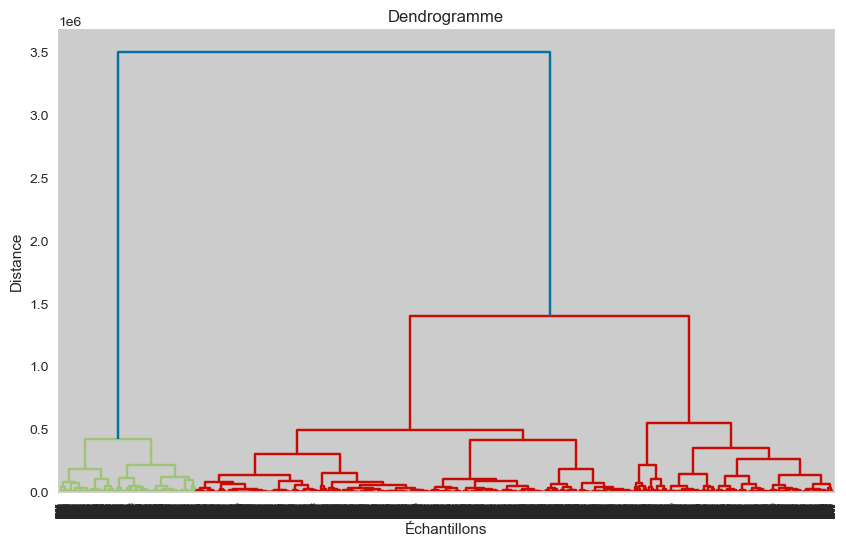

In [83]:
import scipy.cluster.hierarchy as sch

# Calculer la matrice de distances
dist_matrix = sch.distance.pdist(X) 

# Calculer le lien hiérarchique
linkage = sch.linkage(dist_matrix, method='ward')

# Tracer le dendrogramme
plt.figure(figsize=(10, 6))
sch.dendrogram(linkage)
plt.title("Dendrogramme")
plt.xlabel("Échantillons")
plt.ylabel("Distance")
plt.savefig('dendogramme')
plt.show()


Le clustering hiérarchique nous confirme le choix de 3 clusters. 

In [230]:
df_final=data_rfm_num_feat

In [231]:
df_final.to_csv('df_final.csv', index=False)